# BEATS DMM commissioning - Process results of energy scans

### STRIPE 1 - [Ru/B4C]65 - d-spacing: 4.0 nm
- Mo 0.2 mm
- Cu 0.0125 mm

### STRIPE 2 - [W/B4C]100 - d-spacing: 2.5 nm
- Mo 0.2 mm
- Pd 0.05 mm
- In 0.1 mm

______________________________________________________

Author:         Gianluca Iori (gianthk.iori@gmail.com)

Created on:   29/11/2023

Last update:  30/11/2023
______________________________________________________


In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# plt.style.use('seaborn-v0_8-talk')
plt.style.use('seaborn-v0_8-notebook')
# plt.style.use('tableau-colorblind10')
# plt.style.use('default')

In [8]:
%matplotlib inline
font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

In [9]:
def deg2rad(angle_deg):
    return angle_deg*(np.pi)/180

def rad2deg(angle_rad):
    return angle_rad*180/np.pi

# 1. STRIPE 2 - [W/B4C]100 - d-spacing: 2.5 nm
## 1.1 Edge scans results and multilayer parameters

In [10]:
stripe1_edge_theta_deg = np.array([-0.73166, -0.60108, -0.35582]) # [deg] These are the angles corresponding to K-edges found with energy scans of metal foils (Mo, Pd, In). In our lab reference grazing angles are negative
stripe1_edge_theta = deg2rad(stripe1_edge_theta_deg)

stripe1_edge_en = np.array([20000., 24350., 33169.]) # [eV] - K-edge energies for Mo, Pd, and In
stripe1_edge_lambda = 1239.842/stripe1_edge_en # [nm] - Corresponding K-edge wavelenghts
stripe1_d_nominal = 2.5 # [nm] - Nominal d-spacing of STRIPE 2

## 1.2 Parameter space for optimization of refraction-corrected Bragg law
From [Christian Morawe; Multilayer based x-ray optics at the ESRF. AIP Conf. Proc. 15 January 2019; 2054 (1): 060002. https://doi.org/10.1063/1.5084633](https://pubs.aip.org/aip/acp/article/2054/1/060002/1023470/Multilayer-based-x-ray-optics-at-the-ESRF):

> A periodic ML is a stack of alternating thin layers of different optical density. It reflects an incoming electromagnetic wave efficiently under Bragg condition, i.e. when all amplitudes emerging from all bi-layers add up in phase.

> The refraction corrected Bragg equation for a ML with d-spacing d is expressed as:

$$
  m \lambda = 2 d \sqrt{n^2 - \cos^2{\theta}}
$$

Where, $\theta$ is the grazing angle of incidence, _n_ is the average refractive index of the ML stack, $\lambda$ is the wavelength, and _m_ is the order of the Bragg peak.

We consider _m=1_, and we try to optimize the following 2 parameters:
- _n_ - average refractive index of the multilayer
- _d_ - effective multilayer d-spacing

In [31]:
n_start = 0.9999999
n_end = 1.00003
d_start = 2.0
d_end = 2.6

n = np.arange(n_start, n_end, (1-0.9999999)) # average refractive index of the multilayer
d = np.arange(d_start, d_end, 0.001) # effective d-spacing

## 1.3 Calculate refraction-corrected Bragg angle for a _n_ - _d_ space:
We also calculate the difference between theoretical value and the angle we measured with energy scans

In [12]:
theta_refraction = np.zeros([n.size, d.size, stripe1_edge_lambda.size], dtype='float')
theta_refraction_diff = np.zeros(theta_refraction.shape, dtype='float')
for ni in range(0, n.size):
    for di in range(0, d.size):
        for li in range(0, stripe1_edge_lambda.size):
            # compute refraction-corrected Bragg angle for a n-d space
            theta_refraction[ni, di, li] = -np.arccos(np.sqrt(n[ni]**2-(stripe1_edge_lambda[li]/(2*d[di]))**2))

            # difference with experimental values
            theta_refraction_diff[ni, di, li] = np.abs(theta_refraction[ni, di, li] - stripe1_edge_theta[li])

/tmp/ipykernel_51495/2721694070.py:7: RuntimeWarning: invalid value encountered in arccos
  theta_refraction[ni, di, li] = -np.arccos(np.sqrt(n[ni]**2-(stripe1_edge_lambda[li]/(2*d[di]))**2))


## 1.4 Minimize the distance between predicted and measured values (for all 3 angles)

In [13]:
theta_refraction_std = np.std(theta_refraction_diff, 2)
theta_refraction_var = np.var(theta_refraction_diff, 2)
theta_refraction_sum = np.sum(theta_refraction_diff, 2)

### 1.4.1 Find global maximum

In [69]:
from numpy import unravel_index
min_index = unravel_index(np.nanargmin(theta_refraction_sum), theta_refraction_sum.shape)
# print(min_index)

d_opt = d[min_index[1]]
n_opt = n[min_index[0]]

print('Optimal d-spacing:', d_opt, '[nm]')
print('Optimal refractive index n:', n_opt)

Optimal d-spacing: 2.2149999999999763 [nm]
Optimal refractive index n: 1.0000162999999915


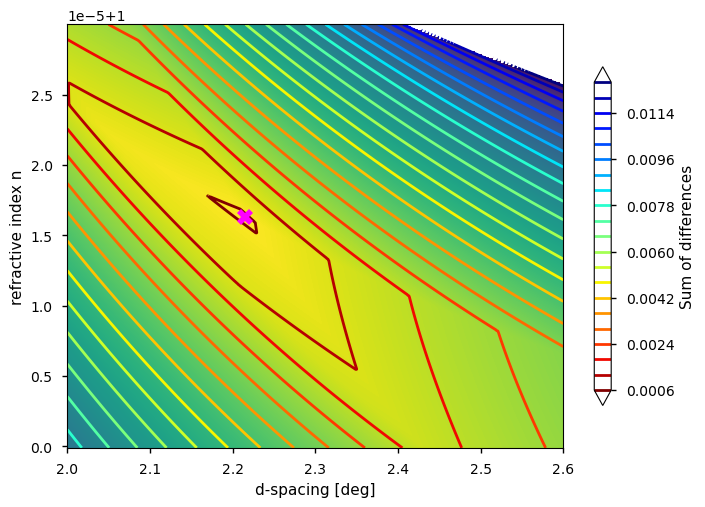

In [72]:
fig, ax = plt.subplots()
plt.xlabel("d-spacing [deg]")
plt.ylabel("refractive index n")

im = ax.imshow(theta_refraction_sum, cmap=plt.cm.viridis_r, interpolation='bilinear', origin='lower', extent=(d_start, d_end, n_start, n_end)) # extent=[-3, 3, -3, 3], cmap=plt.cm.RdBu
CS = ax.contour(d, n, theta_refraction_sum, levels=20, origin='lower', cmap='jet_r', extend='both', linewidths=2, extent=(d_start, d_end, n_start, n_end)) # extent=[-3, 3, -3, 3]
CB = fig.colorbar(CS, shrink=0.8)
CB.set_label('Sum of differences')

optimum = ax.plot(d_opt, n_opt, color='magenta', marker='X', markersize=12)

ax.set_aspect('auto')
# plt.colorbar(im)
plt.show()